# Notebook for running experiments with OpenAI models


In [17]:
import pandas as pd
import numpy as np
from openai import OpenAI
from dotenv import load_dotenv # pip install python-dotenv
load_dotenv()   # Set API KEY values from .env file


True

In [18]:
dataset = pd.read_csv("data/ipcc_statements_dataset_original_cleaned_context.csv")
test_set = dataset[dataset["split"]=="test"]
train_set = dataset[dataset["split"]=="train"]


In [19]:
test_set.head()

,Unnamed: 0.1,Unnamed: 0,statement_idx,report,page_num,sent_num,original_statement,final_statement,confidence,score,split,context,has_confidence_in_final_statement
3,3,0,3,AR6_WGI,24,2,"Since 1750, increases in CO 2 (47%) and CH 4 (...","Since 1750, increases in CO2 (47%) and CH4 (15...",very high,3,test,Estimates account for both direct emissions in...,False
42,42,1,42,AR6_WGI,37,16,"Over the next 2000 years, global mean sea leve...","Over the next 2000 years, global mean sea leve...",low,0,test,Continued ice loss over the 21st century is vi...,False
77,77,2,77,AR6_WGI,47,7,"By the end of the century, scenarios with very...","By the end of the century, scenarios with very...",high,2,test,"{6.6, 6.7, Box TS.7}. D.2.3 Scenarios with ver...",False
81,81,3,81,AR6_WGI,62,2,"Over the past millennium, and especially since...","Over the past millennium, and especially since...",medium,1,test,"{1.3.2, 1.5.1, Cross-Chapter Boxes 2.1 and 2.4...",False
86,86,4,86,AR6_WGI,63,8,This paleo context supports the assessment tha...,The paleo context supports the assessment that...,high,2,test,"For example, under a past global warming level...",False


## Define Prompt

Currently uses the same prompt for zero-shot experiments as from the original workshop paper, but we can try tuning/adjusting, maybe with DSPy.

In [20]:
def get_original_prompt(statement):
    return f"""
You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.       

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.

---

Follow the following format.

Statement: ${{a short statement about climate.}}
Confidence: ${{must be *only*: 'low', 'medium', 'high', 'very high'}}

---
Statement: {statement}
Confidence: """

In [21]:
def get_refined_prompt(statement):
    return f"""
You are a helpful and knowledgeable climate science and policy assistant trained to assess human expert confidence in statements about climate change.

You will be presented with a sentence about climate science, the impacts of climate change, or mitigation of climate change, retrieved or paraphrased from the 6th IPCC assessment report. 

This statement has been labeled as low, medium, high, or very high confidence by a consensus of climate experts, based on the type, quality, quantity, and consistency of scientific evidence available.

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'.

Statement: {statement}
Confidence: """

## Choose Model

In [6]:
client = OpenAI()
MODEL = "gpt-3.5-turbo"

## Helper Functions for running experiments

In [22]:
import re
# Get a normalized classification string from the model's raw response
def extract_confidence(text):
    if re.search(r"low", text, re.IGNORECASE):
        return "low"
    elif re.search(r"medium", text, re.IGNORECASE):
        return "medium"
    elif re.search(r"very high", text, re.IGNORECASE):
        return "very high"
    elif re.search(r"high", text, re.IGNORECASE):
        return "high"
    elif re.search(r"i don't know", text, re.IGNORECASE):
        return "idk"
    else:
        return "N/A"

In [23]:
import numpy as np 

# Prompt the model and get raw response, normalized response, logprobs
def query_openai_model(client, statement, prompt_fn): 
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "user", "content": prompt_fn(statement)}
            ],
            temperature=0, 
            logprobs=True,
            top_logprobs=5
        )
    raw_output = response.choices[0].message.content
    cleaned_output = extract_confidence(raw_output)
    top_logprobs = response.choices[0].logprobs.content[0].top_logprobs
    logprobs = [(logprob.token, logprob.logprob, np.round(np.exp(logprob.logprob)*100,2)) for logprob in top_logprobs]
    return pd.Series([raw_output, cleaned_output, logprobs])

In [24]:
# Query the model. n_sc = number of times to run the experiment, for self-consistency.
def run_experiment(dataset, n_sc, prompt_fn):
    for i in range(1, n_sc+1):
        dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_logprobs{i}"]] = dataset["final_statement"].apply(lambda x: query_openai_model(client, x, prompt_fn))
    return dataset
                                                                                                                   

In [10]:
original_prompt_experiment_df = test_set
original_prompt_experiment_df = run_experiment(original_prompt_experiment_df, 5, get_original_prompt) 

/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_19363/493120235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_logprobs{i}"]] = dataset["final_statement"].apply(lambda x: query_openai_model(client, x, prompt_fn))
/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_19363/493120235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_logp

## Run experiments

In [11]:
original_prompt_experiment_df.head()

,Unnamed: 0.1,Unnamed: 0,statement_idx,report,page_num,sent_num,original_statement,final_statement,confidence,score,...,model_logprobs2,raw_output_3,model_confidence_classification_3,model_logprobs3,raw_output_4,model_confidence_classification_4,model_logprobs4,raw_output_5,model_confidence_classification_5,model_logprobs5
3,3,0,3,AR6_WGI,24,2,"Since 1750, increases in CO 2 (47%) and CH 4 (...","Since 1750, increases in CO2 (47%) and CH4 (15...",very high,3,...,"[(high, -0.28075963, 75.52), (very, -1.928663,...",high,high,"[(high, -0.6262981, 53.46), (very, -0.90776557...",high,high,"[(high, -0.28075963, 75.52), (very, -1.928663,...",high,high,"[(high, -0.45065174, 63.72), (High, -1.6593386..."
42,42,1,42,AR6_WGI,37,16,"Over the next 2000 years, global mean sea leve...","Over the next 2000 years, global mean sea leve...",low,0,...,"[(high, -0.21719944, 80.48), (medium, -2.38334...",high,high,"[(high, -0.5750035, 56.27), (High, -1.3472413,...",high,high,"[(high, -0.3251872, 72.24), (High, -2.1403995,...",high,high,"[(high, -0.5750035, 56.27), (High, -1.3472413,..."
77,77,2,77,AR6_WGI,47,7,"By the end of the century, scenarios with very...","By the end of the century, scenarios with very...",high,2,...,"[(High, -0.07981266, 92.33), (high, -3.1122644...",High,high,"[(High, -0.07037741, 93.2), (high, -3.3502598,...",high,high,"[(high, -0.10116621, 90.38), (High, -2.7497506...",high,high,"[(high, -0.10116621, 90.38), (High, -2.7497506..."
81,81,3,81,AR6_WGI,62,2,"Over the past millennium, and especially since...","Over the past millennium, and especially since...",medium,1,...,"[(Medium, -0.7572334, 46.9), (High, -1.3412483...",High,high,"[(High, -0.7199574, 48.68), (Medium, -0.894138...",High,high,"[(High, -0.6578959, 51.79), (high, -1.5878752,...",high,high,"[(high, -1.1319208, 32.24), (High, -1.2416449,..."
86,86,4,86,AR6_WGI,63,8,This paleo context supports the assessment tha...,The paleo context supports the assessment that...,high,2,...,"[(High, -0.12052948, 88.65), (high, -2.6163027...",High,high,"[(High, -0.06014387, 94.16), (Medium, -3.57057...",High,high,"[(High, -0.24230175, 78.48), (high, -1.9765623...",High,high,"[(High, -0.12052948, 88.65), (high, -2.6163027..."


In [12]:
original_prompt_experiment_df.to_csv("results/cleaned_dataset/gpt_3.5_turbo_sc_original_prompt_02062024.csv")

In [13]:
manually_adjusted_prompt_experiment_df = test_set
manually_adjusted_prompt_experiment_df = run_experiment(manually_adjusted_prompt_experiment_df, 5, get_refined_prompt) 

/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_19363/493120235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_logprobs{i}"]] = dataset["final_statement"].apply(lambda x: query_openai_model(client, x, prompt_fn))


In [14]:
manually_adjusted_prompt_experiment_df.head()


,Unnamed: 0.1,Unnamed: 0,statement_idx,report,page_num,sent_num,original_statement,final_statement,confidence,score,...,model_logprobs2,raw_output_3,model_confidence_classification_3,model_logprobs3,raw_output_4,model_confidence_classification_4,model_logprobs4,raw_output_5,model_confidence_classification_5,model_logprobs5
3,3,0,3,AR6_WGI,24,2,"Since 1750, increases in CO 2 (47%) and CH 4 (...","Since 1750, increases in CO2 (47%) and CH4 (15...",very high,3,...,"[(very, -0.26219758, 76.94), (high, -1.8315755...",very high,very high,"[(very, -0.55882174, 57.19), (high, -1.0458517...",very high,very high,"[(very, -0.32500747, 72.25), (high, -1.3966112...",very high,very high,"[(very, -0.70310915, 49.5), (high, -0.94703615..."
42,42,1,42,AR6_WGI,37,16,"Over the next 2000 years, global mean sea leve...","Over the next 2000 years, global mean sea leve...",low,0,...,"[(high, -0.2503565, 77.85), (very, -1.7351835,...",high,high,"[(high, -0.30375373, 73.8), (very, -1.5606812,...",high,high,"[(high, -0.30375373, 73.8), (very, -1.5606812,...",high,high,"[(high, -0.30375373, 73.8), (very, -1.5606812,..."
77,77,2,77,AR6_WGI,47,7,"By the end of the century, scenarios with very...","By the end of the century, scenarios with very...",high,2,...,"[(high, -0.051866032, 94.95), (High, -3.323812...",high,high,"[(high, -0.06281204, 93.91), (High, -3.1143773...",high,high,"[(high, -0.057264157, 94.43), (High, -3.497783...",high,high,"[(high, -0.06340621, 93.86), (High, -3.142832,..."
81,81,3,81,AR6_WGI,62,2,"Over the past millennium, and especially since...","Over the past millennium, and especially since...",medium,1,...,"[(high, -0.108506784, 89.72), (High, -3.069488...",high,high,"[(high, -0.11171214, 89.43), (medium, -2.84784...",high,high,"[(high, -0.18426313, 83.17), (medium, -2.10391...",high,high,"[(high, -0.14385542, 86.6), (medium, -2.222991..."
86,86,4,86,AR6_WGI,63,8,This paleo context supports the assessment tha...,The paleo context supports the assessment that...,high,2,...,"[(high, -0.2844433, 75.24), (very, -1.9404014,...",high,high,"[(high, -0.4823573, 61.73), (High, -1.4303515,...",high,high,"[(high, -0.32000154, 72.61), (very, -1.7426109...",high,high,"[(high, -0.32000154, 72.61), (very, -1.7426109..."


In [15]:
manually_adjusted_prompt_experiment_df.to_csv("results/cleaned_dataset/gpt_3.5_turbo_sc_manually_adjusted_prompt_02062024.csv")

## Analyze results

In [7]:
manually_adjusted_prompt_experiment_df = pd.read_csv("results/cleaned_dataset/gpt_3.5_turbo_sc_manually_adjusted_prompt_02062024.csv")
original_prompt_experiment_df = pd.read_csv("results/cleaned_dataset/gpt_3.5_turbo_sc_original_prompt_02062024.csv")

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

def get_metrics(results_df, model_classification_col_name):
    true_labels = results_df.loc[(results_df[model_classification_col_name] != 'N/A') & (results_df[model_classification_col_name] != 'idk'), 'confidence']
    predicted_labels = results_df.loc[(results_df[model_classification_col_name] != 'N/A') & (results_df[model_classification_col_name] != 'idk'), model_classification_col_name]

    # Compute macro F1 score
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    print("Macro F1 score:", f1)

    # Compute weighted F1 score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print("Weighted F1 score:", f1)

    # Compute precision for each class
    precision = precision_score(true_labels, predicted_labels, average=None)

    # Compute recall for each class
    recall = recall_score(true_labels, predicted_labels, average=None)

    # Compute F1 score for each class
    f1 = f1_score(true_labels, predicted_labels, average=None)

    # Create a dataframe to store precision and recall for each class
    class_metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1': f1})

    # Add labels to the class metrics dataframe
    class_metrics_df['Class'] = true_labels.unique().astype(str)

    # Sort the dataframe by class index or name
    class_metrics_df = class_metrics_df.sort_values('Class', key=lambda x: pd.Categorical(x, categories=["low", "medium", "high", "very high"]))

    # Print class metrics dataframe
    #print(class_metrics_df)

    # Compute accuracy for the whole system
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Compute accuracy by class

    print("Accuracy (total):", accuracy)

    report = classification_report(true_labels, predicted_labels, digits=4)
    print(report)

    # Count classes
    category_counts = true_labels.value_counts()
    print(category_counts)



In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_confidence_assessment(results_df, model_classification_col_name):
    # Filter samples
    fs = results_df.loc[(results_df[model_classification_col_name] != 'N/A') & (results_df[model_classification_col_name] != 'idk')] 

    # Compute a certainty score
    value_map = {'low': 0, 'medium': 1, 'high': 2, 'very high': 3}

    fs['predicted_score'] = fs[model_classification_col_name].apply(
        lambda x: value_map[x])

    # Break down scores
    scores_all = {
        "low": fs.loc[fs['score'] == 0, 'predicted_score'].mean(),
        "medium": fs.loc[fs['score'] == 1, 'predicted_score'].mean(),
        "high": fs.loc[fs['score'] == 2, 'predicted_score'].mean(),
        "very high": fs.loc[fs['score'] == 3, 'predicted_score'].mean()
    }

    scores_wg1 = {
        "low": fs.loc[(fs['score'] == 0) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
        "medium": fs.loc[(fs['score'] == 1) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
        "high": fs.loc[(fs['score'] == 2) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
        "very high": fs.loc[(fs['score'] == 3) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean()
    }

    scores_wg23 = {
        "low": fs.loc[(fs['score'] == 0) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
        "medium": fs.loc[(fs['score'] == 1) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
        "high": fs.loc[(fs['score'] == 2) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
        "very high": fs.loc[(fs['score'] == 3) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean()
    }

    print("=== All AR6 reports===")
    print(f"Average ground truth score: {results_df['score'].mean()}")
    print(f"Average predicted score: {fs['predicted_score'].mean()}")
    print(f"Average scores per category: {scores_all}\n")

    print("=== AR6 WGI report ===")
    print(f"Average ground truth score: {results_df.loc[results_df['report'] == 'AR6_WGI', 'score'].mean()}")
    print(f"Average predicted score: {fs.loc[fs['report'] == 'AR6_WGI', 'predicted_score'].mean()}")
    print(f"Average scores per category: {scores_wg1}\n")

    print("=== AR6 WGII/III reports ===")
    print(f"Average ground truth score: {results_df.loc[results_df['report'] != 'AR6_WGI', 'score'].mean()}")
    print(f"Average predicted score: {fs.loc[fs['report'] != 'AR6_WGI', 'predicted_score'].mean()}")
    print(f"Average scores per category: {scores_wg23}\n")

    # Extract labels and values from the data dictionary
    labels = list(scores_all.keys())
    values_all = list(scores_all.values())
    values_wg1 = list(scores_wg1.values())
    values_wg23 = list(scores_wg23.values())

    # Define the custom labels for the x-axis
    x_labels = ['0 (Low)', '1 (Medium)', '2 (High)', '3 (Very high)']

    # Create the line plot with labeled curve
    sns.lineplot(x=labels, y=values_all, label='Average prediction')
    sns.lineplot(x=labels, y=values_wg1, linestyle='--', color="steelblue", label='WG1 report')
    sns.lineplot(x=labels, y=values_wg23, linestyle='dotted', color="steelblue", label='WG2 & WG3 report')


    # Add the ground truth line (y = x)
    x = np.arange(len(labels))
    plt.plot(x, x, linestyle='--', color='red', label='Ground truth')

    # Customize the x-axis tick labels
    plt.xticks(labels, x_labels)

    # Set the y-axis limits
    plt.ylim(0, 3)

    # Set the title and labels
    plt.title("Average predicted certainty level per class")
    plt.xlabel("Label")
    plt.ylabel("Value")

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()

Macro F1 score: 0.26144939784220916
Weighted F1 score: 0.3357786843024327
Accuracy (total): 0.4066666666666667
              precision    recall  f1-score   support

        high     0.4679    0.5100    0.4880       100
         low     0.5000    0.0200    0.0385        50
      medium     0.3690    0.6900    0.4808       100
   very high     0.5000    0.0200    0.0385        50

    accuracy                         0.4067       300
   macro avg     0.4592    0.3100    0.2614       300
weighted avg     0.4456    0.4067    0.3358       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.37
Average scores per category: {'low': 1.08, 'medium': 1.32, 'high': 1.5, 'very high': 1.5}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.5894736842105264
Average scores per category: {'low': 1.25, 'medium': 1.6, '

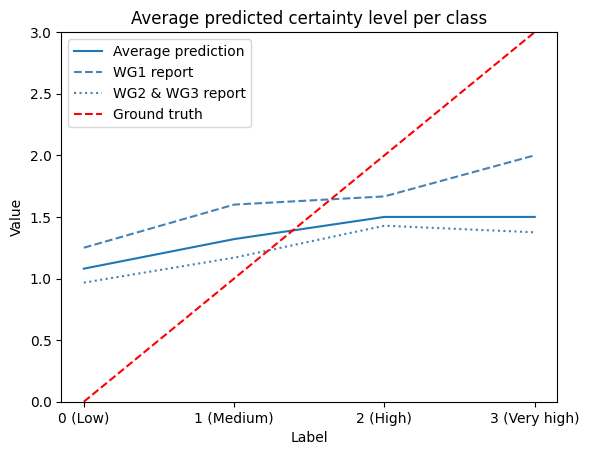

Macro F1 score: 0.25894833677852547
Weighted F1 score: 0.33256488445167687
Accuracy (total): 0.4033333333333333
              precision    recall  f1-score   support

        high     0.4796    0.4700    0.4747       100
         low     0.3333    0.0200    0.0377        50
      medium     0.3655    0.7200    0.4848       100
   very high     0.5000    0.0200    0.0385        50

    accuracy                         0.4033       300
   macro avg     0.4196    0.3075    0.2589       300
weighted avg     0.4206    0.4033    0.3326       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.33
Average scores per category: {'low': 1.08, 'medium': 1.27, 'high': 1.46, 'very high': 1.44}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.5473684210526315
Average scores per category: {'low': 1.25, 'medium': 1.5

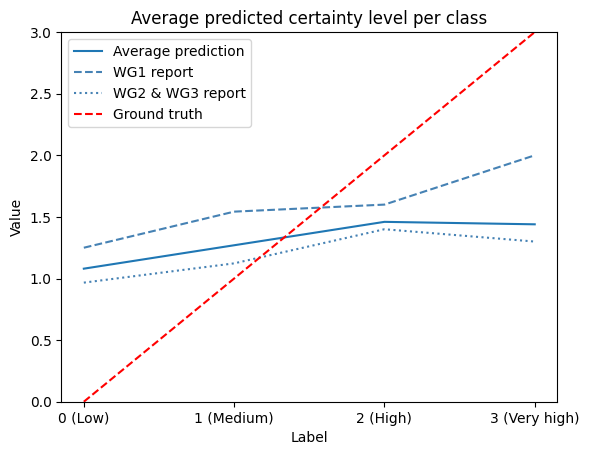

Macro F1 score: 0.25628006465226266
Weighted F1 score: 0.32888624004917066
Accuracy (total): 0.4
              precision    recall  f1-score   support

        high     0.4486    0.4800    0.4638       100
         low     0.5000    0.0200    0.0385        50
      medium     0.3704    0.7000    0.4844       100
   very high     0.5000    0.0200    0.0385        50

    accuracy                         0.4000       300
   macro avg     0.4547    0.3050    0.2563       300
weighted avg     0.4397    0.4000    0.3289       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.3633333333333333
Average scores per category: {'low': 1.1, 'medium': 1.31, 'high': 1.47, 'very high': 1.52}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.5789473684210527
Average scores per category: {'low': 1.3, 'medium': 1.6, '

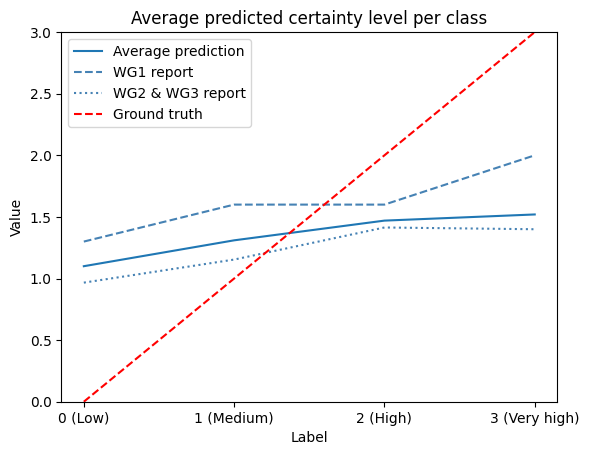

Macro F1 score: 0.25854700854700857
Weighted F1 score: 0.33190883190883186
Accuracy (total): 0.4033333333333333
              precision    recall  f1-score   support

        high     0.4537    0.4900    0.4712       100
         low     0.5000    0.0200    0.0385        50
      medium     0.3723    0.7000    0.4861       100
   very high     0.5000    0.0200    0.0385        50

    accuracy                         0.4033       300
   macro avg     0.4565    0.3075    0.2585       300
weighted avg     0.4420    0.4033    0.3319       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.3666666666666667
Average scores per category: {'low': 1.12, 'medium': 1.31, 'high': 1.48, 'very high': 1.5}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.6
Average scores per category: {'low': 1.35, 'medium': 1.6, 

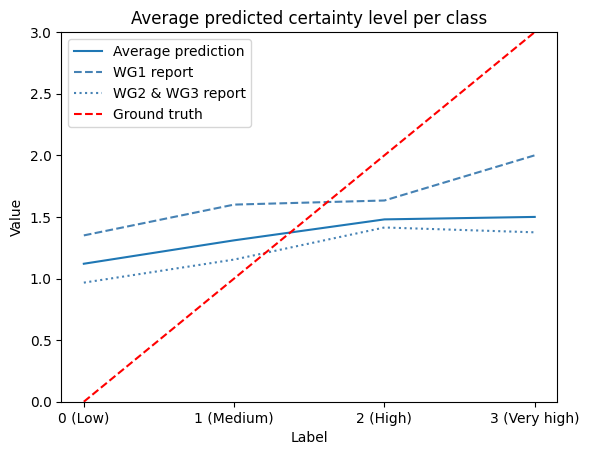

Macro F1 score: 0.2549225485682482
Weighted F1 score: 0.3270762186038181
Accuracy (total): 0.39666666666666667
              precision    recall  f1-score   support

        high     0.4495    0.4900    0.4689       100
         low     0.5000    0.0200    0.0385        50
      medium     0.3636    0.6800    0.4739       100
   very high     0.5000    0.0200    0.0385        50

    accuracy                         0.3967       300
   macro avg     0.4533    0.3025    0.2549       300
weighted avg     0.4377    0.3967    0.3271       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.37
Average scores per category: {'low': 1.1, 'medium': 1.33, 'high': 1.48, 'very high': 1.5}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.5789473684210527
Average scores per category: {'low': 1.25, 'medium': 1.6, '

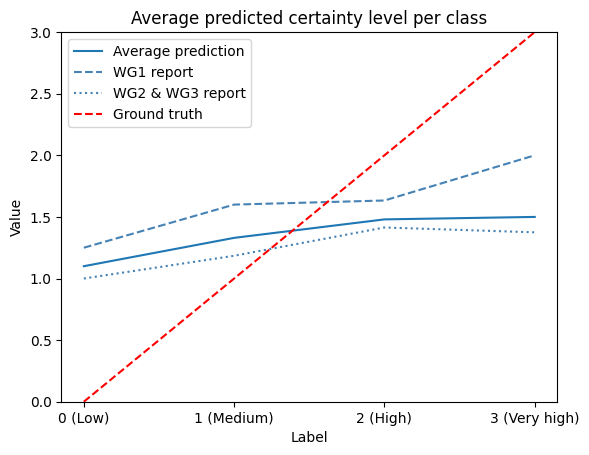

In [12]:
for n in range(1, 6): 
    model_classification_col_name=f"model_confidence_classification_{n}"
    get_metrics(original_prompt_experiment_df, model_classification_col_name)
    get_confidence_assessment(original_prompt_experiment_df, model_classification_col_name)

Macro F1 score: 0.24350644212636324
Weighted F1 score: 0.31185474334797153
Accuracy (total): 0.4
              precision    recall  f1-score   support

        high     0.4155    0.8600    0.5603       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3556    0.3200    0.3368       100
   very high     1.0000    0.0400    0.0769        50

    accuracy                         0.4000       300
   macro avg     0.4428    0.3050    0.2435       300
weighted avg     0.4237    0.4000    0.3119       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7
Average scores per category: {'low': 1.34, 'medium': 1.66, 'high': 1.86, 'very high': 1.82}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8105263157894738
Average scores per category: {'low': 1.45, 'medium': 1.8285714285714285,

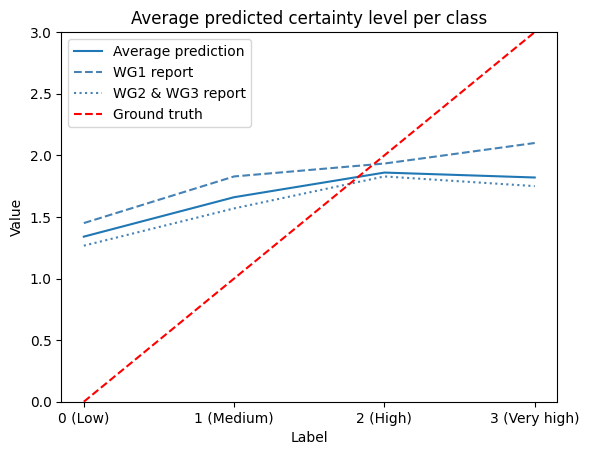

Macro F1 score: 0.2402582145661329
Weighted F1 score: 0.3077656697359759
Accuracy (total): 0.39666666666666667
              precision    recall  f1-score   support

        high     0.4104    0.8700    0.5577       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3614    0.3000    0.3279       100
   very high     0.6667    0.0400    0.0755        50

    accuracy                         0.3967       300
   macro avg     0.3596    0.3025    0.2403       300
weighted avg     0.3684    0.3967    0.3078       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.72
Average scores per category: {'low': 1.38, 'medium': 1.69, 'high': 1.86, 'very high': 1.84}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.831578947368421
Average scores per category: {'low': 1.5, 'medium': 1.8571

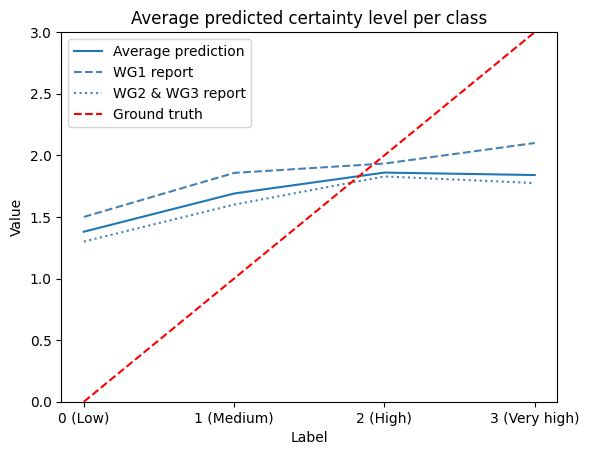

Macro F1 score: 0.23866569863917503
Weighted F1 score: 0.30564231516669876
Accuracy (total): 0.3933333333333333
              precision    recall  f1-score   support

        high     0.4038    0.8600    0.5495       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3659    0.3000    0.3297       100
   very high     0.6667    0.0400    0.0755        50

    accuracy                         0.3933       300
   macro avg     0.3591    0.3000    0.2387       300
weighted avg     0.3676    0.3933    0.3056       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7233333333333334
Average scores per category: {'low': 1.44, 'medium': 1.69, 'high': 1.85, 'very high': 1.82}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8421052631578947
Average scores per category: {'low': 1.5, 

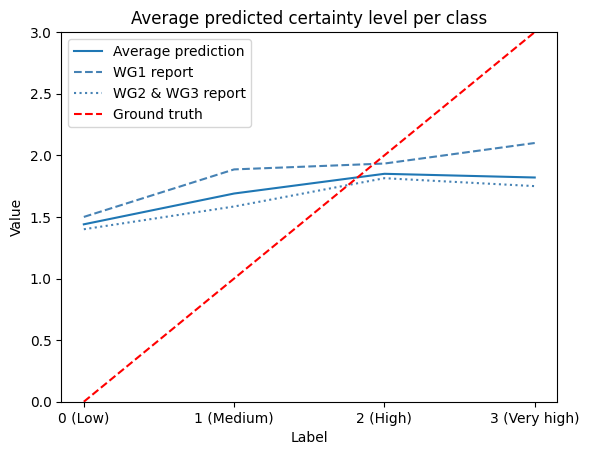

Macro F1 score: 0.238140657504759
Weighted F1 score: 0.30470036385249916
Accuracy (total): 0.3933333333333333
              precision    recall  f1-score   support

        high     0.4019    0.8600    0.5478       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3614    0.3000    0.3279       100
   very high     1.0000    0.0400    0.0769        50

    accuracy                         0.3933       300
   macro avg     0.4408    0.3000    0.2381       300
weighted avg     0.4211    0.3933    0.3047       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7233333333333334
Average scores per category: {'low': 1.4, 'medium': 1.68, 'high': 1.86, 'very high': 1.86}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.831578947368421
Average scores per category: {'low': 1.55, 'me

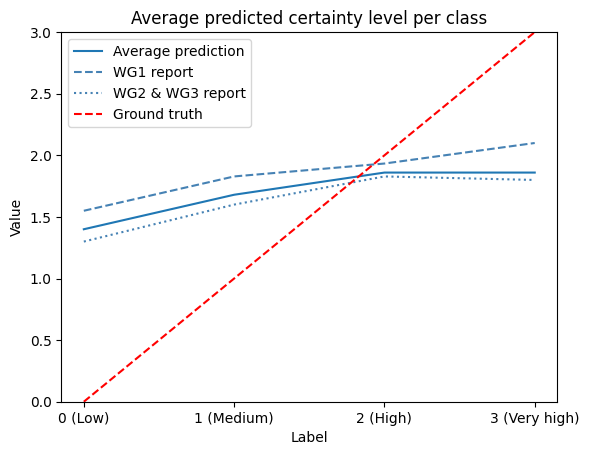

Macro F1 score: 0.23707365986110907
Weighted F1 score: 0.3035195967959441
Accuracy (total): 0.3933333333333333
              precision    recall  f1-score   support

        high     0.4047    0.8700    0.5524       100
         low     0.0000    0.0000    0.0000        50
      medium     0.3580    0.2900    0.3204       100
   very high     0.6667    0.0400    0.0755        50

    accuracy                         0.3933       300
   macro avg     0.3573    0.3000    0.2371       300
weighted avg     0.3653    0.3933    0.3035       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7333333333333334
Average scores per category: {'low': 1.4, 'medium': 1.7, 'high': 1.87, 'very high': 1.86}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8526315789473684
Average scores per category: {'low': 1.5, 'me

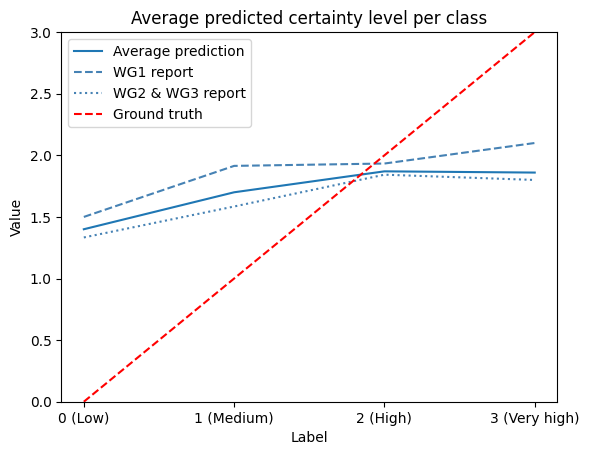

In [13]:
for n in range(1, 6): 
    model_classification_col_name=f"model_confidence_classification_{n}"
    get_metrics(manually_adjusted_prompt_experiment_df, model_classification_col_name)
    get_confidence_assessment(manually_adjusted_prompt_experiment_df, model_classification_col_name)

## Try again with GPT-4o

In [14]:
client = OpenAI()
MODEL = "gpt-4o"

In [25]:
original_prompt_experiment_df = test_set
original_prompt_experiment_df = run_experiment(original_prompt_experiment_df, 5, get_original_prompt) 
original_prompt_experiment_df.to_csv("results/cleaned_dataset/gpt_4o_sc_original_prompt_02062024.csv")

/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_20027/1099700625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_logprobs{i}"]] = dataset["final_statement"].apply(lambda x: query_openai_model(client, x, prompt_fn))
/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_20027/1099700625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_lo

In [26]:
manually_adjusted_prompt_experiment_df = test_set
manually_adjusted_prompt_experiment_df = run_experiment(manually_adjusted_prompt_experiment_df, 5, get_refined_prompt) 
manually_adjusted_prompt_experiment_df.to_csv("results/cleaned_dataset/gpt_4o_sc_manually_adjusted_prompt_02062024.csv")

/var/folders/zw/vnb4lkhd14n9cx0d71_qh_z00000gn/T/ipykernel_20027/1099700625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}", f"model_logprobs{i}"]] = dataset["final_statement"].apply(lambda x: query_openai_model(client, x, prompt_fn))


In [27]:
manually_adjusted_prompt_experiment_df = pd.read_csv("results/cleaned_dataset/gpt_4o_sc_manually_adjusted_prompt_02062024.csv")
original_prompt_experiment_df = pd.read_csv("results/cleaned_dataset/gpt_4o_sc_original_prompt_02062024.csv")

Macro F1 score: 0.32323391233111803
Weighted F1 score: 0.3794171844879685
Accuracy (total): 0.4266666666666667
              precision    recall  f1-score   support

        high     0.4497    0.6700    0.5382       100
         low     0.5000    0.0400    0.0741        50
      medium     0.3953    0.5100    0.4454       100
   very high     0.4444    0.1600    0.2353        50

    accuracy                         0.4267       300
   macro avg     0.4474    0.3450    0.3232       300
weighted avg     0.4391    0.4267    0.3794       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.6033333333333333
Average scores per category: {'low': 1.14, 'medium': 1.48, 'high': 1.81, 'very high': 1.9}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.768421052631579
Average scores per category: {'low': 1.2, 'me

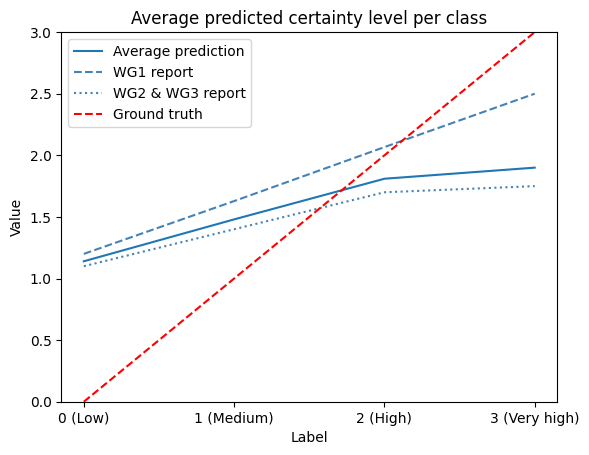

Macro F1 score: 0.3465422780281765
Weighted F1 score: 0.3925847464380905
Accuracy (total): 0.43
              precision    recall  f1-score   support

        high     0.4533    0.6800    0.5440       100
         low     0.6667    0.0800    0.1429        50
      medium     0.3884    0.4700    0.4253       100
   very high     0.4348    0.2000    0.2740        50

    accuracy                         0.4300       300
   macro avg     0.4858    0.3575    0.3465       300
weighted avg     0.4642    0.4300    0.3926       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.6333333333333333
Average scores per category: {'low': 1.1, 'medium': 1.53, 'high': 1.86, 'very high': 1.92}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.831578947368421
Average scores per category: {'low': 1.15, 'medium': 1.77142

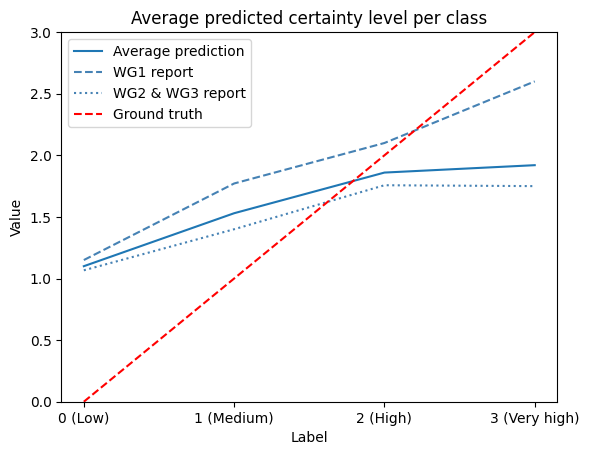

Macro F1 score: 0.32931736557403146
Weighted F1 score: 0.38044784545673327
Accuracy (total): 0.42333333333333334
              precision    recall  f1-score   support

        high     0.4558    0.6700    0.5425       100
         low     0.5000    0.0400    0.0741        50
      medium     0.3780    0.4800    0.4229       100
   very high     0.4545    0.2000    0.2778        50

    accuracy                         0.4233       300
   macro avg     0.4471    0.3475    0.3293       300
weighted avg     0.4370    0.4233    0.3804       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.6233333333333333
Average scores per category: {'low': 1.14, 'medium': 1.51, 'high': 1.85, 'very high': 1.88}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.7894736842105263
Average scores per category: {'low': 1.2,

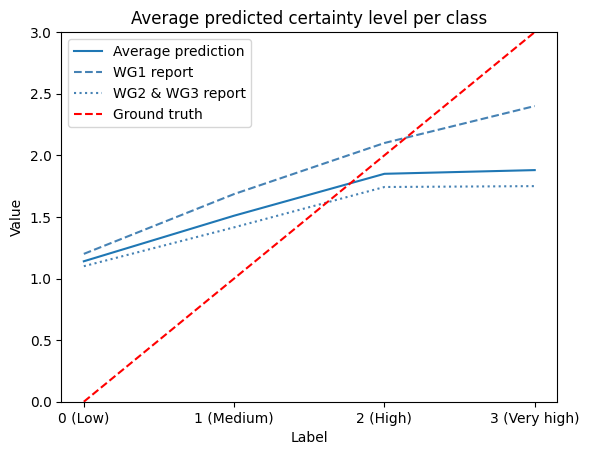

Macro F1 score: 0.3599467418546366
Weighted F1 score: 0.4034878863826232
Accuracy (total): 0.43666666666666665
              precision    recall  f1-score   support

        high     0.4500    0.6300    0.5250       100
         low     0.6667    0.0800    0.1429        50
      medium     0.4062    0.5200    0.4561       100
   very high     0.4615    0.2400    0.3158        50

    accuracy                         0.4367       300
   macro avg     0.4961    0.3675    0.3599       300
weighted avg     0.4735    0.4367    0.4035       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.62
Average scores per category: {'low': 1.1, 'medium': 1.48, 'high': 1.83, 'very high': 2.0}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.7789473684210526
Average scores per category: {'low': 1.15, 'medium': 1.6857

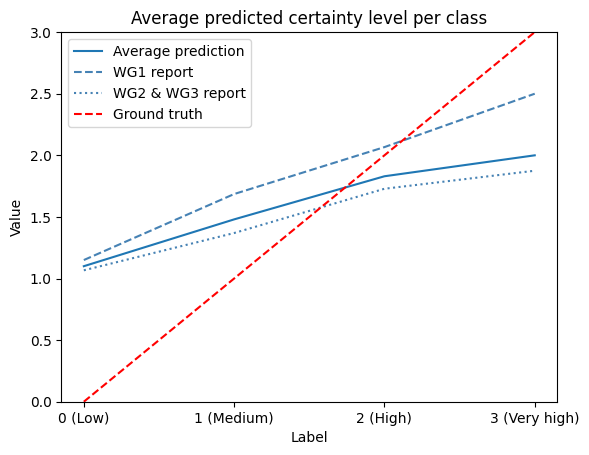

Macro F1 score: 0.3151326661566449
Weighted F1 score: 0.37378184673588566
Accuracy (total): 0.42333333333333334
              precision    recall  f1-score   support

        high     0.4474    0.6800    0.5397       100
         low     0.6667    0.0400    0.0755        50
      medium     0.3968    0.5000    0.4425       100
   very high     0.3684    0.1400    0.2029        50

    accuracy                         0.4233       300
   macro avg     0.4698    0.3400    0.3151       300
weighted avg     0.4539    0.4233    0.3738       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.6233333333333333
Average scores per category: {'low': 1.16, 'medium': 1.51, 'high': 1.86, 'very high': 1.84}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8
Average scores per category: {'low': 1.2, 'medium': 1.685

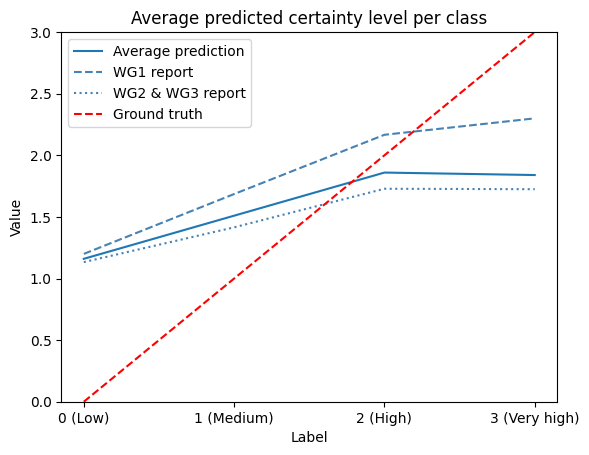

In [28]:
for n in range(1, 6): 
    model_classification_col_name=f"model_confidence_classification_{n}"
    get_metrics(original_prompt_experiment_df, model_classification_col_name)
    get_confidence_assessment(original_prompt_experiment_df, model_classification_col_name)

Macro F1 score: 0.3629449942281644
Weighted F1 score: 0.404128679172906
Accuracy (total): 0.44333333333333336
              precision    recall  f1-score   support

        high     0.4270    0.7600    0.5468       100
         low     0.8000    0.0800    0.1455        50
      medium     0.4699    0.3900    0.4262       100
   very high     0.4118    0.2800    0.3333        50

    accuracy                         0.4433       300
   macro avg     0.5272    0.3775    0.3629       300
weighted avg     0.5009    0.4433    0.4041       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.8033333333333332
Average scores per category: {'low': 1.18, 'medium': 1.62, 'high': 2.1, 'very high': 2.2}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.894736842105263
Average scores per category: {'low': 1.25, 'med

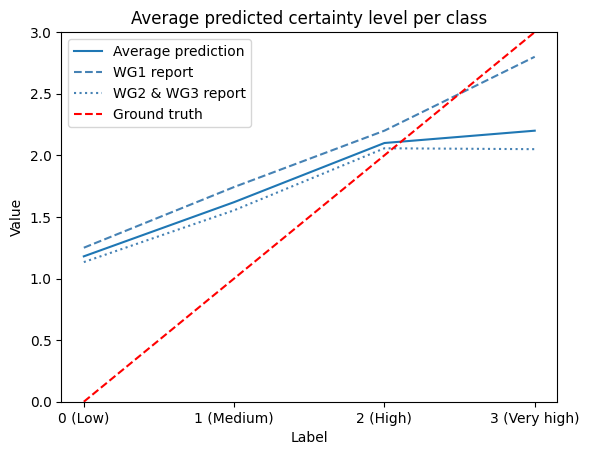

Macro F1 score: 0.34415552408199357
Weighted F1 score: 0.39144309508201797
Accuracy (total): 0.44
              precision    recall  f1-score   support

        high     0.4333    0.7800    0.5571       100
         low     0.6667    0.0400    0.0755        50
      medium     0.4432    0.3900    0.4149       100
   very high     0.4483    0.2600    0.3291        50

    accuracy                         0.4400       300
   macro avg     0.4979    0.3675    0.3442       300
weighted avg     0.4780    0.4400    0.3914       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7833333333333334
Average scores per category: {'low': 1.22, 'medium': 1.62, 'high': 2.04, 'very high': 2.16}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8736842105263158
Average scores per category: {'low': 1.2, 'medium': 1.74

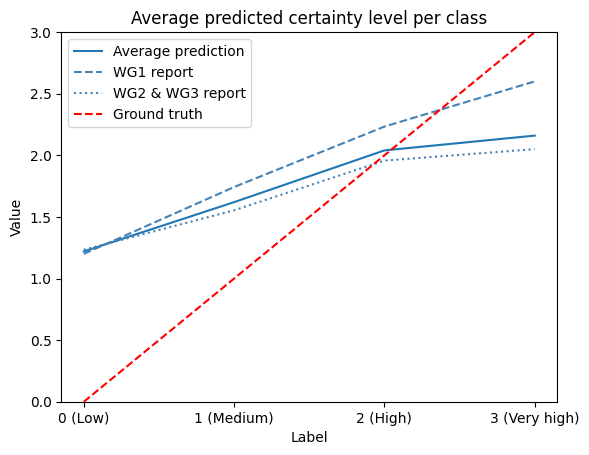

Macro F1 score: 0.3387774473635562
Weighted F1 score: 0.3848610809077341
Accuracy (total): 0.43
              precision    recall  f1-score   support

        high     0.4286    0.7500    0.5455       100
         low     0.6667    0.0400    0.0755        50
      medium     0.4419    0.3800    0.4086       100
   very high     0.3889    0.2800    0.3256        50

    accuracy                         0.4300       300
   macro avg     0.4815    0.3625    0.3388       300
weighted avg     0.4661    0.4300    0.3849       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.8133333333333332
Average scores per category: {'low': 1.2, 'medium': 1.64, 'high': 2.11, 'very high': 2.18}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8421052631578947
Average scores per category: {'low': 1.15, 'medium': 1.7714

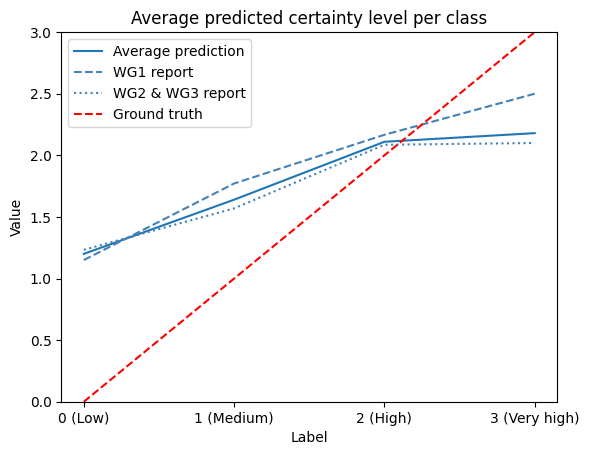

Macro F1 score: 0.34645129981817285
Weighted F1 score: 0.3918292463184104
Accuracy (total): 0.43333333333333335
              precision    recall  f1-score   support

        high     0.4302    0.7400    0.5441       100
         low     0.7500    0.0600    0.1111        50
      medium     0.4444    0.4000    0.4211       100
   very high     0.3824    0.2600    0.3095        50

    accuracy                         0.4333       300
   macro avg     0.5018    0.3650    0.3465       300
weighted avg     0.4803    0.4333    0.3918       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7866666666666666
Average scores per category: {'low': 1.18, 'medium': 1.63, 'high': 2.06, 'very high': 2.16}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8421052631578947
Average scores per category: {'low': 1.15,

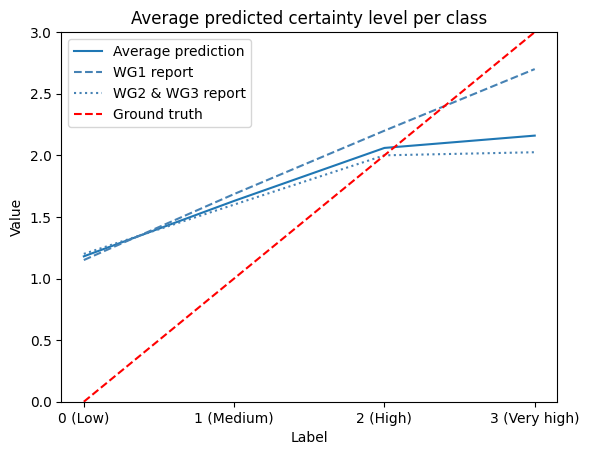

Macro F1 score: 0.3652362878782328
Weighted F1 score: 0.408939389128649
Accuracy (total): 0.45
              precision    recall  f1-score   support

        high     0.4464    0.7500    0.5597       100
         low     0.7500    0.0600    0.1111        50
      medium     0.4468    0.4200    0.4330       100
   very high     0.4412    0.3000    0.3571        50

    accuracy                         0.4500       300
   macro avg     0.5211    0.3825    0.3652       300
weighted avg     0.4963    0.4500    0.4089       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.7733333333333334
Average scores per category: {'low': 1.14, 'medium': 1.59, 'high': 2.07, 'very high': 2.18}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8736842105263158
Average scores per category: {'low': 1.15, 'medium': 1.7428

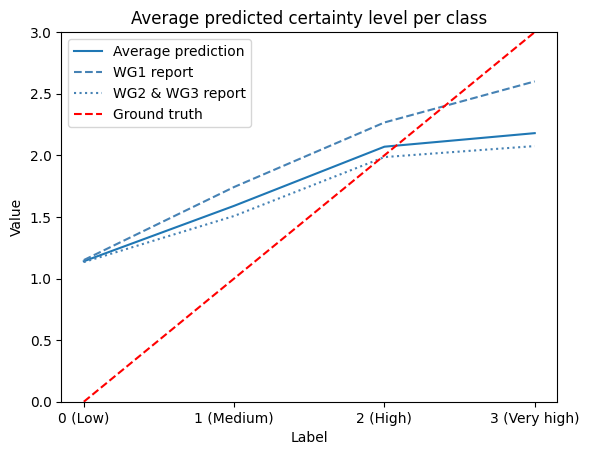

In [29]:
for n in range(1, 6): 
    model_classification_col_name=f"model_confidence_classification_{n}"
    get_metrics(manually_adjusted_prompt_experiment_df, model_classification_col_name)
    get_confidence_assessment(manually_adjusted_prompt_experiment_df, model_classification_col_name)